In [242]:
%reset

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [19]:
data = pd.read_csv('./company_stock_prices/AMZN.csv', 
                    header=0, 
                    usecols=['Date', 'Close'], 
                    parse_dates=True, 
                    index_col= 'Date')

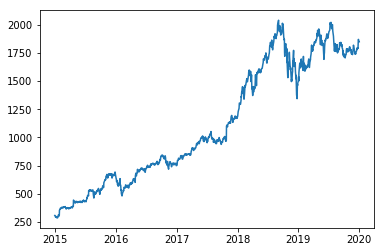

In [20]:
plt.plot(data['Close'])
plt.show()

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [22]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [23]:
# 70-30 split
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [24]:
def create_dataset(dataset, timestep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep - 1):
        data_x.append(dataset[i: (i+timestep), 0])
        data_y.append(dataset[i + timestep, 0])
    return np.array(data_x), np.array(data_y)

In [25]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

In [26]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [28]:
def create_model():
    model = Sequential()

    # Adding the first LSTM layer
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (train_x.shape[1], 1)))

    # Adding a second LSTM layer
    model.add(LSTM(units = 50, return_sequences = True))
    
    # Adding a third LSTM layer
    model.add(LSTM(units = 50, return_sequences = True))

    # Adding a fourth LSTM layer
    model.add(LSTM(units = 50))

    # Adding the output layer
    model.add(Dense(units = 1)) 
    return model

In [29]:
def compile_and_run(model, epochs, batch_size):
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(train_x, train_y, verbose=0)
    return history, score

In [30]:
def plot_metrics(history):
    metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
    metrics_df.plot()
    plt.xlabel("No. of Epochs")
    plt.ylabel("Loss")

In [31]:
stacked_LSTM_model = create_model()
print(stacked_LSTM_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
history, score = compile_and_run(stacked_LSTM_model, epochs=30, batch_size=64) 
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/30
14/14 [==============================] - 0s 5ms/step - loss: 0.1208 - accuracy: 0.0011
Epoch 2/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0838 - accuracy: 0.0011
Epoch 3/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0424 - accuracy: 0.0011
Epoch 4/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0329 - accuracy: 0.0011
Epoch 5/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0266 - accuracy: 0.0011
Epoch 6/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0196 - accuracy: 0.0011
Epoch 7/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0101 - accuracy: 0.0011
Epoch 8/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.0011
Epoch 9/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 0.0011
Epoch 10/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 0.0011
Epoch 11/30
14/14 [

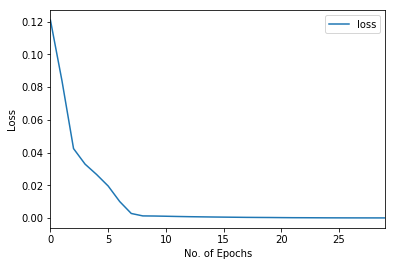

In [33]:
plot_metrics(history)

In [34]:
train_predictions = stacked_LSTM_model.predict(train_x)
test_predictions = stacked_LSTM_model.predict(test_x)

In [35]:
train_predictions = scaler.inverse_transform(train_predictions)
train_y = scaler.inverse_transform([train_y])

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

In [36]:
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:,:] = np.nan
train_predict_plot[1:len(train_predictions)+1, :] = train_predictions

In [37]:
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predictions)+2+1 : len(scaled_data)-1, :] = test_predictions

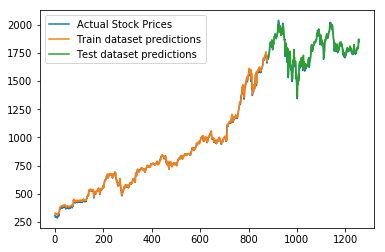

In [38]:
actual_stock_prices, = plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Prices')
train_dataset_prediction, = plt.plot(train_predict_plot, label='Train dataset predictions')
test_dataset_prediction, = plt.plot(test_predict_plot, label='Test dataset predictions')
plt.legend(handles = [actual_stock_prices, train_dataset_prediction, test_dataset_prediction])
plt.show()

In [39]:
test_array = scaler.inverse_transform(scaled_data).flatten()
test_array = test_array[int(len(scaled_data)*0.7+2):int(len(scaled_data))]

test_prediction_flattened = test_predictions.flatten()
df = pd.DataFrame({'Actual Values':test_array, 'Predicted Values':test_prediction_flattened})

In [40]:
def get_error_scores(y_test,y_pred):
  mse = mean_squared_error(y_test,y_pred)
  # rmse = mean_squared_error(y_test, y_pred, squared=False)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  return mse, rmse, mae

In [41]:
mse, rmse, mae = get_error_scores(test_array, test_prediction_flattened)

In [42]:
print('Mean Squared Error: %.3f' % mse)
print('Root Mean Squared Error: %.3f' % rmse)
print('Mean Average Error: %.3f' % mae)

Mean Squared Error: 2081.272
Root Mean Squared Error: 45.621
Mean Average Error: 32.939


Text(0,0.5,'Stock Price (in USD)')

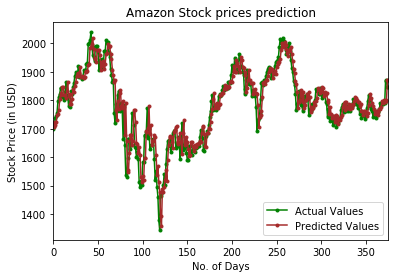

In [47]:
plot = df[['Actual Values', 'Predicted Values']].plot( marker='.',
                                                color=['green', 'brown'], 
                                                title="Amazon Stock prices prediction")
plot.set_xlabel("No. of Days")
plot.set_ylabel("Stock Price (in USD)")